In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from time import strptime
import datetime
from datetime import datetime
import warnings
import time
import csv
import glob
import logging
import importlib
import tweets_utils
# import json
import ujson as json
# import networkx as nx
import seaborn as sns
# import re
# from operator import itemgetter
# import matplotlib.cm as mcm
# import community
# from community import community_louvain as cm
# import leidenalg as la
# import igraph as ig
# from cdlib import algorithms
warnings.filterwarnings('ignore')
%autosave 3600

Autosaving every 3600 seconds


- interazioni con le altre community
- **(done)** se i dozen ne fanno parte 
- caratterizzazione community
- prendi rt di un gruppo e vedi quanti hanno come altro nodo della rete un gruppo all'interno della propria community
    - prime 5, caratterizza (community seguaci, community alto verified, ...)

# Indice

- [Network Script](#script)


- [Network](#network)

    - [Netwrok info](#info)
    - [Load files](#load)
    
    
- [Communities](#communities)

    - [Stats](#stats)    
    - [Rt Disinform Dozen](#rt_dozen)
    - [Disinform Dozen and community](#dozen_comm)
    - [Good Dozen and community](#good_comm)
    - [Top communities](#top_comm)
    - [Community degrees](#degrees_comm)

# Network Script
<a id="script"/>

In [ ]:
retweets_graph = nx.from_pandas_edgelist(df,'name','rt_name', create_using=nx.DiGraph())
print(nx.info(retweets_graph)) #da ritornare le info
#-----------------------------------------------------------------
degree_dict = dict(retweets_graph.degree(retweets_graph.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True) #da ritornare il dictionary
#-----------------------------------------------------------------
in_degree_dict = dict(retweets_graph.in_degree(retweets_graph.nodes()))
sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True) #da ritornare il dictionary
#-----------------------------------------------------------------
out_degree_dict = dict(retweets_graph.out_degree(retweets_graph.nodes()))
sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True) #da ritornare il dictionary
#-----------------------------------------------------------------
#### Communities with Louvain modularity
retweets_graph_und = nx.from_pandas_edgelist(df,'name','rt_name')
print(nx.info(retweets_graph_und)) #da ritornare 
#-----------------------------------------------------------------
best_part = cm.best_partition(retweets_graph_und, random_state=42) #da ritornare il best part
#-----------------------------------------------------------------
#### Communities with Leiden (opzionale, se riesci)
tuples = [tuple(x) for x in df_rt.values]
retweets_graph = ig.Graph.TupleList(tuples, directed = True)
n_vertices = retweets_graph.vcount()
print("Number of vertices:", n_vertices)
print("Number of edges:", retweets_graph.ecount())
print("Density of the graph:", 2*retweets_graph.ecount()/(retweets_graph.vcount()*(retweets_graph.vcount()-1)))
#da ritornare
#-----------------------------------------------------------------
total_degree=0
total_indegree = 0
total_outdegree = 0
for n in range(n_vertices):
    total_degree += retweets_graph.degree(n)
    total_indegree += retweets_graph.indegree(n)
    total_outdegree += retweets_graph.outdegree(n)
print("Average indegree:", total_indegree/n_vertices)
print("Average outdegree:", total_outdegree/n_vertices)
#da ritornare
#-----------------------------------------------------------------
partition = la.find_partition(retweets_graph, la.ModularityVertexPartition)
partition
#da ritornare

# Network
<a id="network"/>

### Nx info
<a id="info"/>
<p>
    
    Type: DiGraph
    Number of nodes: 12513502
    Number of edges: 40027282
    Average in degree: 3.1987
    Average out degree: 3.1987
    
</p>

### Load files
<a id="load"/>

In [2]:
path_degrees = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/rt_network/*degree*.json")
path_communities = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/rt_network/*communities*.json")

In [5]:
start_time = time.perf_counter()
file = open (path_degrees[0],)
degree = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  38.8307504


In [6]:
start_time = time.perf_counter()
file = open (path_degrees[1],)
in_degree = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  190.0366737


In [3]:
start_time = time.perf_counter()
file = open (path_degrees[2],)
out_degree = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  21.468247800000004


In [9]:
start_time = time.perf_counter()
file = open (path_communities[0],)
leiden = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  1.6485553999999638


In [10]:
start_time = time.perf_counter()
file = open (path_communities[1],)
louvain = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  19.932470599999988


# Communities
<a id="communities"/>

In [12]:
path_ccdh_rt = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/ccdh/")
path_disinform = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/")

In [13]:
ccdh_rt = pd.read_csv(path_ccdh_rt[0] + "retweet_users_ccdh.csv")

In [14]:
ccdh_rt_flt = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in louvain])]

In [15]:
disinform = pd.read_csv(path_disinform[0] + "disinformation_users.csv")
good_dozen = pd.read_csv(path_disinform[0] + "good_dozen.csv")

### Stats
<a id="stats"/>

In [16]:
total_users = len(louvain)
total_rt_ccdh = len(ccdh_rt)
found = len(ccdh_rt_flt)
cont = 0
for i in louvain:
    if(louvain.get(i) == 2):
        cont = cont + 1

In [17]:
print(f"Utenti che retweettano i Dozen presenti nella Network: {round((found/total_rt_ccdh)*100,2)}%")
print(f"Che rappresentano il: {round((found/total_users)*100,2)}% della network")
print(f"e rappresentano il: {round((found/cont)*100,2)}% della Community numero 2")

Utenti che retweettano i Dozen presenti nella Network: 48.48%
Che rappresentano il: 0.15% della network
e rappresentano il: 1.86% della Community numero 2


### Rt Disinform Dozen
<a id="rt_dozen"/>

In [18]:
community = []
name = []
rt = []
start_time = time.perf_counter()
for i in ccdh_rt_flt["user_screen_name"]:
    if i in louvain:
        rt.append((i, louvain.get(i)))
for i in range(len(rt)):
    community.append(rt[i][1])
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  0.08470649999998159


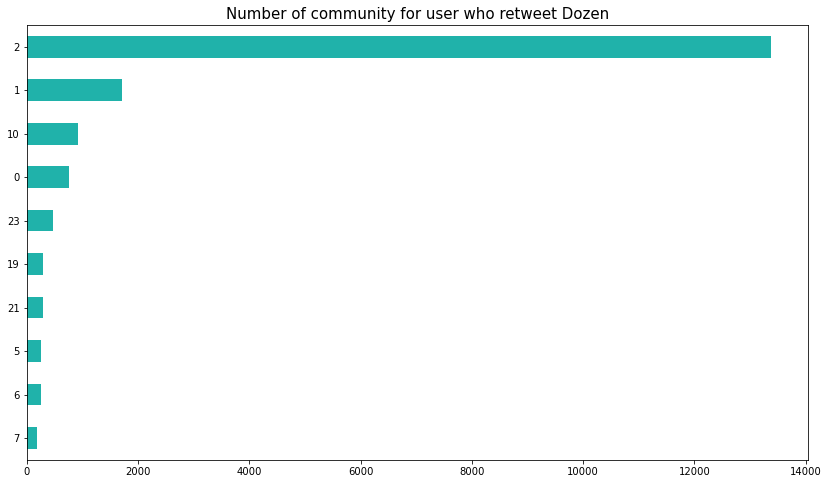

In [19]:
val = pd.Series(community)
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:10].plot(kind='barh', color='lightseagreen', fig=(14,14)) #orange #lightseagreen
ax.set_title('Number of community for user who retweet Dozen', fontsize=15)
ax.invert_yaxis()
plt.show()

### Disinform Dozen and community
<a id="dozen_comm"/>

In [20]:
for i in louvain:
    if i in list(disinform["screen_name"]):
        print(f"Name: {i}, Community: {louvain.get(i)}")

Name: unhealthytruth, Community: 2
Name: BusyDrT, Community: 2
Name: RobertKennedyJr, Community: 2
Name: mercola, Community: 2
Name: kevdjenkins1, Community: 2
Name: DrChrisNorthrup, Community: 2
Name: DrButtar, Community: 2


### Good Dozen and community
<a id="good_comm"/>


In [68]:
for i in louvain:
    if i in list(good_dozen["screen_name"]):
        print(f"Name: {i}, Community: {louvain.get(i)}")

Name: trvrb, Community: 2
Name: CDCDirector, Community: 2
Name: MackayIM, Community: 2
Name: DrTedros, Community: 19
Name: IlonaKickbusch, Community: 2
Name: DrEricDing, Community: 2
Name: kakape, Community: 2
Name: DrDenaGrayson, Community: 1
Name: ashishkjha, Community: 1
Name: mlipsitch, Community: 2
Name: edyong209, Community: 1
Name: HelenBranswell, Community: 1


### Top communities
<a id="top_comm"/>

In [24]:
communities = []
for i in louvain:
    communities.append(louvain.get(i))
val = pd.Series(communities).value_counts().sort_values(ascending=False)

In [58]:
total = 0
total2 = 0
for i in val[:7]:
    total = total + i
print(f"Le prime 7 community contengono il {round(total/len(louvain)*100,2)}% degli utenti su {len(pd.Series(communities).unique())} communities")

Le prime 7 community contengono il 59.92% degli utenti su 325073 communities


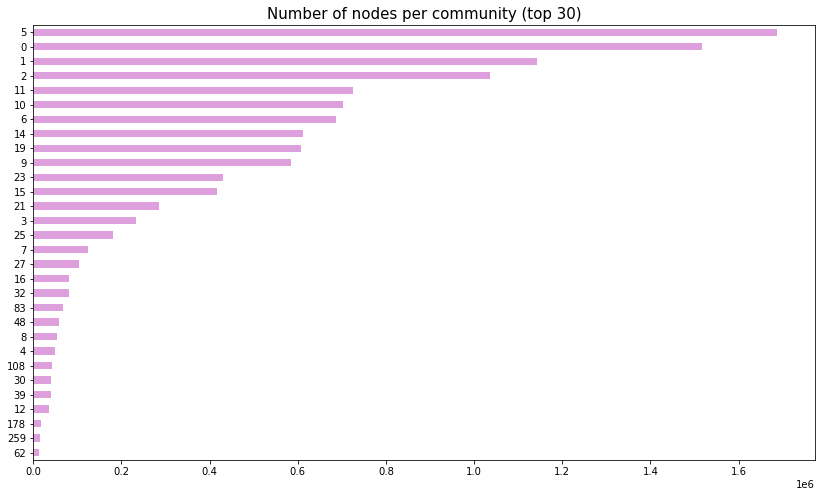

In [71]:
fig = plt.figure(figsize=(14, 8))
ax = val[:30].plot(kind='barh', color='plum', fig=(14,14)) #orange #lightseagreen
ax.set_title('Number of nodes per community (top 30)', fontsize=15)
ax.invert_yaxis()
plt.show()

<p>
    
    5) Utenti comuni, non ci sono testate / influencer / politici / giornalisti
    0) Tutto ciò che riguarda le notizie in spagnolo (Sudamerica e Spagna)
    1) Politici americani / Giornalisti con posizione tendenzialmente di sinistra / Testate giornalistiche
        - DrDenaGrayson (run for congress)
        - ashishkjha (medico)
        - edyong209 (writer at The Atlantic)
        - HelenBranswell (writer)
    2) News meno politiche, più concentrato sulle notizie (maggiori testate al mondo come CNN international,
       BBC world, Time ecc)
        - unhealthytruth
        - BusyDrT
        - RobertKennedyJr
        - mercola
        - kevdjenkins1
        - DrChrisNorthrup
        - DrButtar
        - trvrb
        - CDCDirector
        - MackayIM
        - IlonaKickbusch
        - DrEricDing
        - kakape
        - mlipsitch
    11)
    10)
    6)
    14)
    19)
    
</p>

### Community degrees
<a id="degrees_comm"/>

In [47]:
print("In degree: ")
for i in in_degree[:10000]:
    if i[0] in list(good_dozen["screen_name"]):
        print(f"good: {i}")
    if i[0] in list(disinform["screen_name"]):
        print(f"disinform: {i}")
print("----------------------")
print("Out degree: ")
for i in out_degree[:10000]:
    if i[0] in list(good_dozen["screen_name"]):
        print(f"good: {i}")
    if i[0] in list(disinform["screen_name"]):
        print(f"disinform: {i}")

In degree: 
good: ['DrDenaGrayson', 32737]
good: ['DrTedros', 26854]
good: ['DrEricDing', 23985]
good: ['trvrb', 5936]
good: ['MackayIM', 4291]
good: ['kakape', 3419]
good: ['edyong209', 2810]
good: ['CDCDirector', 2705]
good: ['mlipsitch', 1885]
disinform: ['BusyDrT', 1274]
good: ['HelenBranswell', 1018]
good: ['ashishkjha', 637]
disinform: ['RobertKennedyJr', 579]
----------------------
Out degree: 
good: ['IlonaKickbusch', 233]
good: ['MackayIM', 171]


In [45]:
list_communities = []
list_names = []
for i in degree[:100]:
    list_names.append(i[0])

In [50]:
for i in list_names:
    if i in list(louvain.keys()):
        list_communities.append((i, louvain.get(i)))